# Exploratory Data Analysis LinkedIn Job Posting

### Import The Libraies

In [15]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Handle the LinkedIn job postings DataFrame

In [16]:
df_job = pd.read_csv('linkedin_job_postings.csv')

In [17]:
df_job.head(3)

,job_link,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type
0,https://www.linkedin.com/jobs/view/account-exe...,2024-01-21 07:12:29.00256+00,t,t,f,Account Executive - Dispensing (NorCal/Norther...,BD,"San Diego, CA",2024-01-15,Coronado,United States,Color Maker,Mid senior,Onsite
1,https://www.linkedin.com/jobs/view/registered-...,2024-01-21 07:39:58.88137+00,t,t,f,Registered Nurse - RN Care Manager,Trinity Health MI,"Norton Shores, MI",2024-01-14,Grand Haven,United States,Director Nursing Service,Mid senior,Onsite
2,https://www.linkedin.com/jobs/view/restaurant-...,2024-01-21 07:40:00.251126+00,t,t,f,RESTAURANT SUPERVISOR - THE FORKLIFT,Wasatch Adaptive Sports,"Sandy, UT",2024-01-14,Tooele,United States,Stand-In,Mid senior,Onsite


In [18]:
df_job.shape

(1348454, 14)

In [19]:
df_job.columns

Index(['job_link', 'last_processed_time', 'got_summary', 'got_ner',
       'is_being_worked', 'job_title', 'company', 'job_location', 'first_seen',
       'search_city', 'search_country', 'search_position', 'job_level',
       'job_type'],
      dtype='object')

In [20]:
df_job.drop(columns=['got_summary', 'got_ner', 'is_being_worked'], inplace=True)

In [21]:
df_job.columns

Index(['job_link', 'last_processed_time', 'job_title', 'company',
       'job_location', 'first_seen', 'search_city', 'search_country',
       'search_position', 'job_level', 'job_type'],
      dtype='object')

In [22]:
df_job.isnull().sum()

job_link                0
last_processed_time     0
job_title               0
company                11
job_location           19
first_seen              0
search_city             0
search_country          0
search_position         0
job_level               0
job_type                0
dtype: int64

In [23]:
df_job.dtypes

job_link               object
last_processed_time    object
job_title              object
company                object
job_location           object
first_seen             object
search_city            object
search_country         object
search_position        object
job_level              object
job_type               object
dtype: object

## Finding the Top Words in Job Titles

In [24]:
Words = []
prepositions = set(stopwords.words('english'))
for value in df_job['job_title'].values:
    va = re.sub(r'[^\w\s]', '', value)
    word = va.split()
    word = [w for w in word if w not in prepositions]
    Words.extend(word)

In [25]:
df_word = pd.DataFrame(Words)
df_word.columns = ['Word']

In [26]:
df_word.value_counts().head()

Word    
Manager     252821
Nurse       111096
Senior       97656
RN           86792
Engineer     81214
Name: count, dtype: int64

In [27]:
word = df_word['Word'].value_counts().head(50).index
count = df_word['Word'].value_counts().head(50).values
word_freq = dict(zip(word, count))

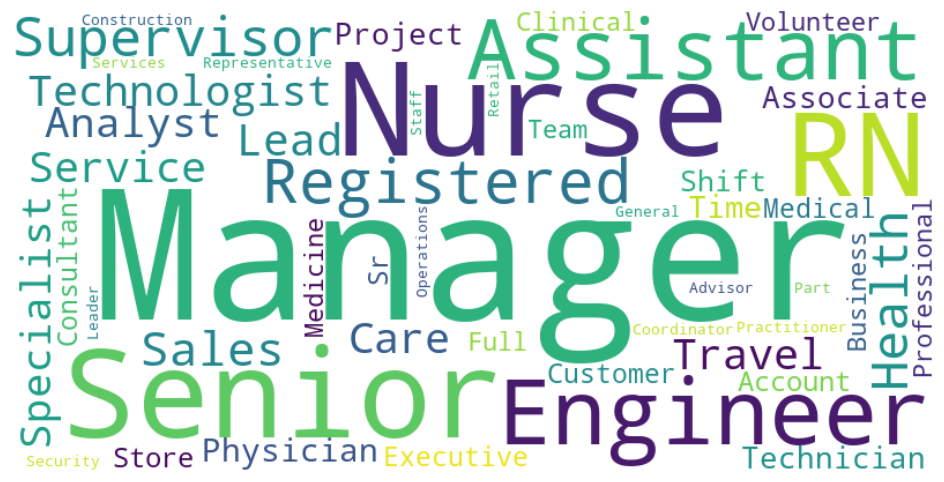

In [28]:
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Export Jobs in the Data Field

In [29]:
def job_data_export(job_title):
    if 'data' in str(job_title).lower() or 'analy' in str(job_title).lower():
        return job_title
    else:
        return None

In [30]:
def job_data(job_title):
    if 'data analyst' in str(job_title).lower():
        return 'data analyst'
    elif 'data engineer' in str(job_title).lower():
        return 'data engineer'
    elif 'data scientist' in str(job_title).lower():
        return 'data scientist'
    else:
        return None

In [31]:
df_job['data_job_title'] = df_job['job_title'].apply(job_data_export)
df_data_job = df_job.dropna(subset='data_job_title').drop(columns='job_title')

In [32]:
df_job['data_job'] = df_job['job_title'].apply(job_data)
df_job_data = df_job.dropna(subset='data_job')

In [33]:
df_data_job.shape

(47225, 11)

In [34]:
df_data_job.drop_duplicates(subset=['data_job_title', 'company',
       'job_location', 'search_country',
       'search_position', 'job_level', 'job_type'], inplace= True)

In [35]:
df_data_job.head()

,job_link,last_processed_time,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,data_job_title
16,https://www.linkedin.com/jobs/view/senior-asso...,2024-01-21 02:01:10.496553+00,KPMG US,"Chicago, IL",2024-01-14,Calumet City,United States,Stand-In,Associate,Onsite,"Senior Associate, Tax - Product Analyst"
19,https://www.linkedin.com/jobs/view/analyst-ass...,2024-01-21 02:01:15.820041+00,RITE AID,"Yocumtown, PA",2024-01-13,Lebanon,United States,Quality Assurance Analyst,Mid senior,Onsite,"Analyst, Associate Plan Configuration & Qualit..."
60,https://ca.linkedin.com/jobs/view/cibc-analyst...,2024-01-19 14:39:10.337464+00,CIBC,"Montreal, Quebec, Canada",2024-01-16,Dorval,Canada,Occupational Analyst,Mid senior,Onsite,"CIBC | Analyste Principal, Intégration des cli..."
165,https://www.linkedin.com/jobs/view/research-an...,2024-01-19 18:34:48.379679+00,Duke University,"Durham, NC",2024-01-16,Raleigh,United States,Investment Analyst,Mid senior,Onsite,RESEARCH ANALYST II
343,https://www.linkedin.com/jobs/view/secret-clea...,2024-01-20 04:02:10.555393+00,Latitude Inc,"Crystal City, VA",2024-01-13,Virginia,United States,Quality Assurance Analyst,Mid senior,Onsite,Secret cleared Business Analyst


##  Combine the Job DataFrame and Skills DataFrame

In [36]:
df_skill = pd.read_csv('job_skills.csv')

In [37]:
df_data_job = df_skill.merge(df_data_job, how='inner', on='job_link')

In [38]:
df_data_job.head()

,job_link,job_skills,last_processed_time,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,data_job_title
0,https://www.linkedin.com/jobs/view/school-base...,"Applied Behavior Analysis (ABA), Data analysis...",2024-01-19 09:45:09.215838+00,CCRES Educational and Behavioral Health Services,"Boyertown, PA",2024-01-13,Exeter,United States,Consultant Education,Mid senior,Onsite,School-based Behavior Analyst
1,https://ca.linkedin.com/jobs/view/performance-...,"SAP, DRMIS, Data warehousing, Data analysis, D...",2024-01-19 09:45:09.215838+00,Bell Flight,"Mirabel, Quebec, Canada",2024-01-13,Côte-Saint-Luc,Canada,Consultant Education,Associate,Onsite,Performance Analyst ( Material) – Analyste per...
2,https://www.linkedin.com/jobs/view/insurance-a...,"Excel, Risk Management, Property Management, I...",2024-01-19 09:45:09.215838+00,City of Boise,"Boise, ID",2024-01-13,Idaho,United States,Consultant Education,Associate,Onsite,Insurance Analyst
3,https://www.linkedin.com/jobs/view/benefits-ac...,"Employee Benefits, Premium Accounting, Auditin...",2024-01-19 09:45:09.215838+00,Arctic Slope Regional Corporation,"Anchorage, AK",2024-01-13,Alaska,United States,Consultant Education,Associate,Onsite,Benefits Accounting Analyst
4,https://www.linkedin.com/jobs/view/board-certi...,"Applied Behavior Analysis (ABA) therapy, Funct...",2024-01-19 09:45:09.215838+00,Ascend Autism Group,"Hawthorne, NY",2024-01-13,Montrose,United States,Consultant Education,Mid senior,Onsite,Board Certified Behavior Analyst (BCBA) - West...


## Extract the Top Skill Required for Data Jobs

In [39]:
skills = []
for value in df_data_job['job_skills'].value_counts().index:
    skills.extend(item.strip().title() for item in value.split(','))

In [40]:
skills = pd.DataFrame(skills, columns=['skill'])

## Combine the job dataframe and job description dataframe


In [41]:
#df_summary = pd.read_csv('job_summary.csv')

In [42]:
#df_data_analyst = df_summary.merge(df_data_job, how='inner', on='job_link')
#df_data_analyst.reset_index(drop= True, inplace=True)

In [43]:
#df_data_analyst.to_csv('data_analyst.csv', index=False)

In [44]:
df_data_analyst = pd.read_csv('data_analyst.csv')

## Extract Salary Information from Job Descriptions

Get APIs convert currency from GBP to USD

In [76]:
import requests
api_key = '3e80bf9aec65d0e858d15c85'

# Base URL for the API
base_url = f'https://v6.exchangerate-api.com/v6/{api_key}/latest/'
amount = 100

# Make the API request to get exchange rates
response = requests.get(base_url + 'GBP')
data = response.json()



In [77]:
def salary_export(summary):
    if 'salary' in summary.lower():
        if re.search(r'\$', summary):
            match = re.findall(r'\$([\d,]+)', summary)
            split = [(s.replace(',', '')) for s in match]
            salary = [int(num) for num in split if len(num) >= 5]
            return salary[:2]
        elif re.search(r'\£', summary):
            match = re.findall(r'\£([\d,]+)', summary)
            split = [(s.replace(',', '')) for s in match]
            salary = [int(num) * data['conversion_rates']['USD'] for num in split if len(num) >= 5]
            return salary[:2]

In [78]:
df_salary = df_data_analyst['job_summary'].apply(lambda x: pd.Series(salary_export(x)))
df_salary.columns = ['min', 'max']

In [79]:
df_salary.dropna(subset=['min'],inplace=True)

In [80]:
df_salary['max'] = df_salary['max'].fillna(df_salary['min'])

In [81]:
df_salary.dtypes

min    float64
max    float64
dtype: object

In [82]:
df_salary[['min', 'max']] = df_salary[['min', 'max']].astype(int)

In [83]:
df_salary['Average'] = (df_salary.iloc[:, 0] + df_salary.iloc[:, 1])/2

In [84]:
df_salary.sort_values(by='Average', ascending=False).head()

,min,max,Average
7878,350000000,350000000,350000000.0
18241,10000000,10000000,10000000.0
7167,843635,843635,843635.0
25798,690000,690000,690000.0
2588,393000,770000,581500.0


In [85]:
df_salary = df_salary[(df_salary['Average']>0) & (df_salary['Average']<1000000)]

In [55]:
#df_salary.to_csv('salary.csv')

## Extract experience Information from Job Descriptions

In [56]:
def experience_export(summary):
    pattern = r'(\d+\+?\s*years?)'
    summary = summary.lower()
    matches =  re.findall(r'\n(.*(?:experience.*years|years.*experience).*)\n', summary)
    for match in matches:
        if re.search(r'a year', match):
            experience = '1 year'
            return experience
        elif re.search(pattern, match) and int(re.search(r'(\d+)\+?\s*years?', match).group(1))<20:
            experience = re.search(pattern, match).group(1)
            return experience
        else:
            return None

In [57]:
df_experience = df_data_analyst['job_summary'].apply(lambda x: pd.Series(experience_export(x)))
df_experience.columns = ['Experience']

In [58]:
df_experience.dropna(inplace=True)

In [59]:
df_experience['Year'] = df_experience['Experience'].str.extract(r'(\d+)').astype(int)

In [60]:
#df_experience.to_csv('experience.csv')

## Combine the salary dataframe and experience dataframe


In [61]:
df_join = df_experience.join(df_salary,  how='inner')

In [62]:
df_join.sort_values(by='Year', ascending=False).head(5)

,Experience,Year,min,max,Average
1127,19 years,19,149900,224900,187400.0
12464,18 years,18,108550,196225,152387.5
35732,16 years,16,75000,100000,87500.0
30891,16+ years,16,81800,186000,133900.0
8891,15 years,15,150000,200000,175000.0


In [63]:
def categorize_experience(year):
    if year >= 0 and year <= 3:
        return 'Beginner'
    elif year >= 4 and year <= 5:
        return 'Junior'
    elif year >= 6 and year <= 10:
        return 'Mid-level'
    else:
        return 'Senior'

In [64]:
df_join['Experience_Segment'] = df_join['Year'].apply(categorize_experience)

In [65]:
df_join.head()

,Experience,Year,min,max,Average,Experience_Segment
3,5 years,5,95000,120000,107500.0,Junior
4,5 years,5,95000,120000,107500.0,Junior
8,5 years,5,106000,130000,118000.0,Junior
16,2 years,2,58906,58906,58906.0,Beginner
22,4 years,4,165100,188500,176800.0,Junior


## Identifying the Best Time to Post a Job

In [66]:
df_data_analyst['last_processed_time'] = pd.to_datetime(df_data_analyst['last_processed_time'])
df_data_analyst['first_seen'] = pd.to_datetime(df_data_analyst['first_seen'])

Text(0.5, 1.0, 'Distribution time post job')

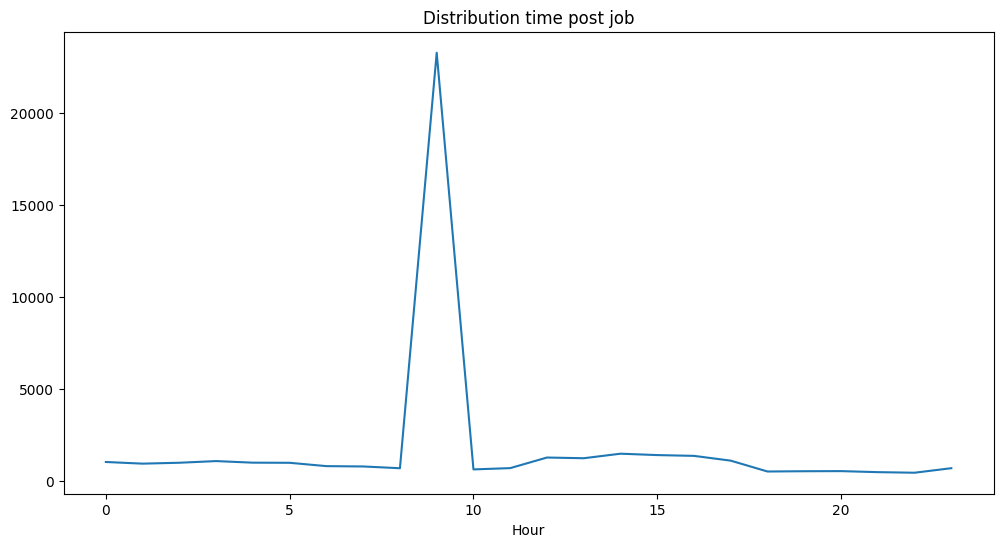

In [67]:
plt.figure(figsize=(12, 6))
df_data_analyst['Hour'] = df_data_analyst['last_processed_time'].dt.hour
df_data_analyst['Hour'].value_counts().sort_index().plot(kind='line')
plt.xlabel('Hour')
plt.title('Distribution time post job')

## Identifying the top skills necessary for data job

In [68]:
data = skills['skill'].value_counts().head(10).to_frame().reset_index()
data

,skill,count
0,Data Analysis,12919
1,Communication,10521
2,Sql,9178
3,Project Management,8813
4,Communication Skills,7514
5,Analytical Skills,6724
6,Problem Solving,6447
7,Python,6212
8,Teamwork,5871
9,Attention To Detail,5705


Text(0.5, 1.0, 'Top skills for data job')

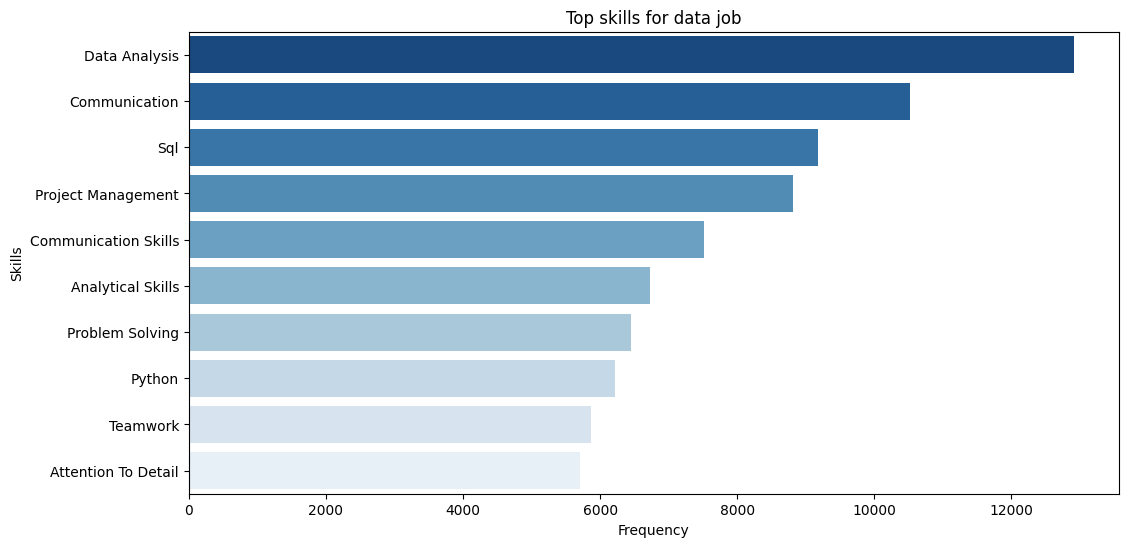

In [69]:
plt.figure(figsize=(12, 6))
palette = sns.color_palette("Blues_r",n_colors=10,)
sns.barplot(data,orient='h', x ='count', y = 'skill', hue='skill', palette=palette)
plt.xlabel('Frequency')
plt.ylabel('Skills')
plt.title('Top skills for data job')

## Distribution of Average Salary

In [70]:
import statistics
Q2_1 = statistics.median(df_join['Average'][df_join['Experience_Segment'] == 'Beginner'])
Q2_2 = statistics.median(df_join['Average'][df_join['Experience_Segment'] == 'Junior'])
Q2_3 = statistics.median(df_join['Average'][df_join['Experience_Segment'] == 'Mid-level'])
Q2_4 = statistics.median(df_join['Average'][df_join['Experience_Segment'] == 'Senior'])
median_value = np.median(df_join['Average'])


Text(0.5, 1.0, 'Distribution of salary for data job')

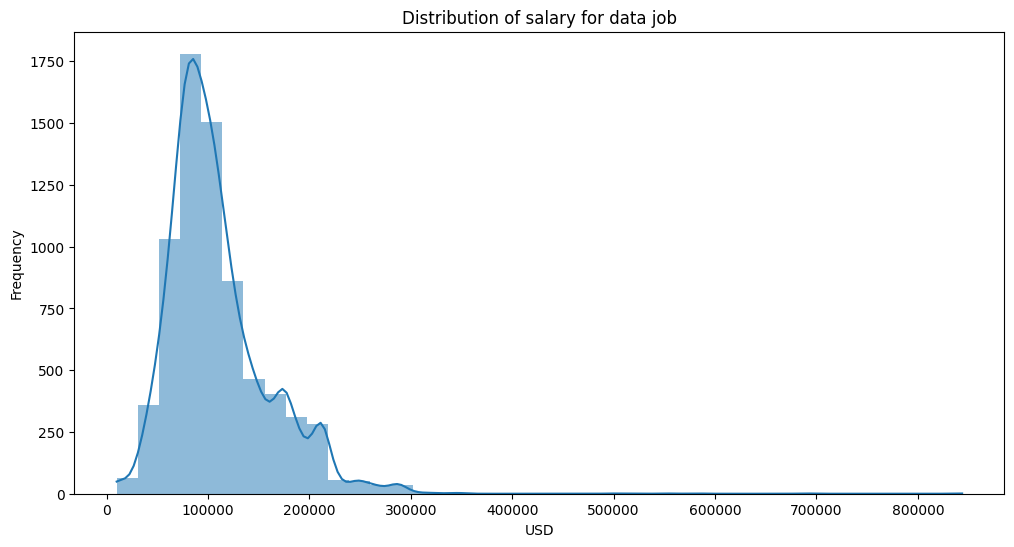

In [95]:
plt.figure(figsize=(12, 6))
sns.histplot(df_salary['Average'], kde=True, linewidth=0, bins=40)
plt.xticks(np.arange(0, 900000, step=100000))
plt.xlabel('USD')
plt.ylabel('Frequency')
plt.title('Distribution of salary for data job')


## Average Salary Distribution by Position

In [72]:
df_join = df_join.sort_values(by='Experience_Segment')

Text(0.5, 1.0, 'Average Salary Distribution by Position')

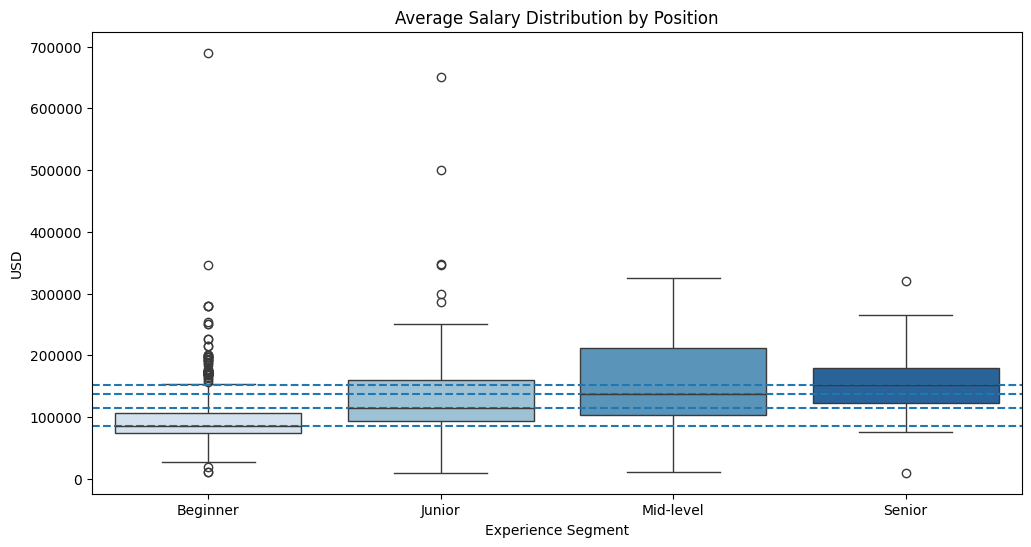

In [87]:
experience_order = ['Beginner', 'Junior', 'Mid-level', 'Senior']
plt.figure(figsize=(12, 6))
palette = sns.color_palette("Blues",n_colors=4)
color = sns.color_palette("Blues",n_colors=1)
sns.boxplot(x='Experience_Segment', y='Average', data=df_join, hue='Experience_Segment', palette=palette)
plt.axhline(Q2_1, linestyle='--')
plt.axhline(Q2_2, linestyle='--')
plt.axhline(Q2_3, linestyle='--')
plt.axhline(Q2_4, linestyle='--')
plt.xlabel('Experience Segment')
plt.ylabel('USD')
plt.title('Average Salary Distribution by Position')